In [1]:
import sys
import numpy as np
import cupy as cp

sys.path.append('../')

from mandala.nodecore import Node
from mandala.nodecore import Variable
from mandala.autodiff import autodiff
from mandala.autodiff import layer
from mandala.autodiff import initializers
from mandala import cuda

In [2]:
import numpy

def linear_forward(x, W, b):
    xp = cuda.get_array_module(x)
    y = xp.matmul(x, W.T)
    if b is not None:
        y += b
    return y


def linear_backward_W(x, gy):
    xp = cuda.get_array_module(x)
    gW = xp.matmul(gy.T, x)
    return gW


def linear_backward_b(b, gy):
    xp = cuda.get_array_module(b)
    gb = gy.sum(axis=0)
    return gb


def linear_backward_x(W, gy):
    xp = cuda.get_array_module(W)
    gx = xp.matmul(gy, W)
    return gx


class LinearFunction(autodiff.AutoDiff):

    def forward(self, xs):
        x, W, b = xs
        y = Node(linear_forward, [x, W, b])
        return y

    def backward(self, xs, gy):
        x, W, b = xs
        gW = Node(linear_backward_W, [x, gy])
        gx = Node(linear_backward_x, [W, gy])
        if b is not None:
            gb = Node(linear_backward_b, [W, gy])
        else:
            gb = None
        return gx, gW, gb


class Linear(layer.Layer):
    def __init__(self, in_ch, out_ch, nobias=False,
                 initializer=initializers.HeNormal):
        self.W = Variable(initializer((out_ch, in_ch)))
        if nobias:
            self.b = None
        else:
            self.b = Variable(numpy.zeros(out_ch, dtype=np.float32))

    def __call__(self, x):
        return LinearFunction()([x, self.W, self.b])


In [29]:
def sum_forward(x):
    xp = cuda.get_array_module(x)
    return xp.sum(x)


def sum_backward(x, gy):
    xp = cuda.get_array_module(x)
    return xp.ones_like(x) * gy


class SumFunction(autodiff.AutoDiff):
    def forward(self, xs):
        x = xs[0]
        y = Node(sum_forward, [x])
        return y

    def backward(self, xs, gy):
        x = xs[0]
        gx = Node(sum_backward, [x, gy])
        return gx,


def _sum(x):
    return SumFunction()([x])

In [30]:
l0 = Linear( 5, 10)
l1 = Linear(10, 10)
l2 = Linear(10,  3)
l0.to_gpu()
l1.to_gpu()
l2.to_gpu()

In [35]:
# 真の係数
W = cp.arange(15, dtype=np.float32).reshape(3, 5)
b = cp.arange(3, dtype=np.float32)
#W = np.zeros((3, 5), dtype=np.float32)

In [36]:
batchsize = 32
x = Variable(cp.random.random((batchsize, 5)).astype(np.float32))
t = Variable(cp.matmul(x.data, W.T) + b)

In [37]:
h0 = l0(x)
h1 = l1(h0)
y  = l2(h1)
loss = (y - t) ** 2 / batchsize

In [38]:
loss.backward()

array([ 53.0451355 , -12.62952423,   3.26362562,  -5.31030893,
       -43.18901062, -11.10464859, -31.76457787, -89.69421387,
        -6.8936615 ,  67.75262451], dtype=float32)

In [44]:
lr = 1e-3

for i in range(100):
    # make batch
    x = Variable(cp.random.random((batchsize, 5)).astype(np.float32))
    t = Variable(cp.matmul(x.data, W.T) + b)
    
    # forward
    h0 = l0(x)
    h1 = l1(h0)
    y  = l2(h1)

    # loss
    loss = _sum((y - t) ** 2) / batchsize
    
    l0.W.grad = 0.
    l1.W.grad = 0.
    l2.W.grad = 0.

    l0.b.grad = 0.
    l1.b.grad = 0.
    l2.b.grad = 0.

    # backward
    loss.backward()
    
    # update
    l0.W.data -= lr * l0.W.grad.data
    l1.W.data -= lr * l1.W.grad.data
    l2.W.data -= lr * l2.W.grad.data

    l0.b.data -= lr * l0.b.grad.data
    l1.b.data -= lr * l1.b.grad.data
    l2.b.data -= lr * l2.b.grad.data

    print(loss.data)

6.62598586131935e-06
6.42754594082362e-06
9.354265785077587e-06
8.916162187233567e-06
1.0415560609544627e-05
9.514661542198155e-06
7.5886505328526255e-06
8.871293175616302e-06
9.18839214136824e-06
7.116397682693787e-06
1.0166131687583402e-05
1.2975053323316388e-05
4.60369665233884e-06
6.646625479334034e-06
7.635513611603528e-06
1.1545951565494761e-05
8.099964361463208e-06
7.038777766865678e-06
1.0046848728961777e-05
7.974688742251601e-06
8.334169251611456e-06
5.583274287346285e-06
7.58110672904877e-06
9.983636118704453e-06
5.0844614634115715e-06
7.090774488460738e-06
4.7985458877519704e-06
9.368335668114014e-06
6.790707629988901e-06
5.6944154493976384e-06
5.9433855312818196e-06
1.0567541721684393e-05
6.070843937777681e-06
8.587279808125459e-06
8.401440936722793e-06
7.876607924117707e-06
5.5211653489095625e-06
5.584422979154624e-06
9.313902410212904e-06
9.20192997000413e-06
5.094047992315609e-06
6.1194114095997065e-06
8.507216989528388e-06
8.760156561038457e-06
7.109493708412629e-06
7.2

In [45]:
y.data[0], t.data[0]

(array([  5.12634373,  21.40603828,  37.68087387], dtype=float32),
 array([  5.12714005,  21.40440941,  37.68167877], dtype=float32))

In [46]:
nodes = []

In [47]:
def get_node(y, nodes):
    nodes.append(y)
    for x in y.args:
        if x not in nodes:
            get_node(x, nodes)

In [53]:
l1.b.data

array([-0.13857451,  0.02909009, -0.02852071,  0.03976426,  0.16466653,
       -0.01560829,  0.10769328,  0.29602829,  0.05121623, -0.15675041], dtype=float32)

In [54]:
get_node(l0.W.grad, nodes)
get_node(l1.W.grad, nodes)
get_node(l2.W.grad, nodes)

In [55]:
get_node(loss, nodes)

In [56]:
nodes

In [57]:
import itertools
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodes)

In [58]:
for node in nodes:
    for n0, n1 in itertools.permutations(nodes, 2):
        if not n1 in n0.args:
            continue
        if not G.has_edge(n0, n1):
            G.add_edge(n1, n0, weight=1)

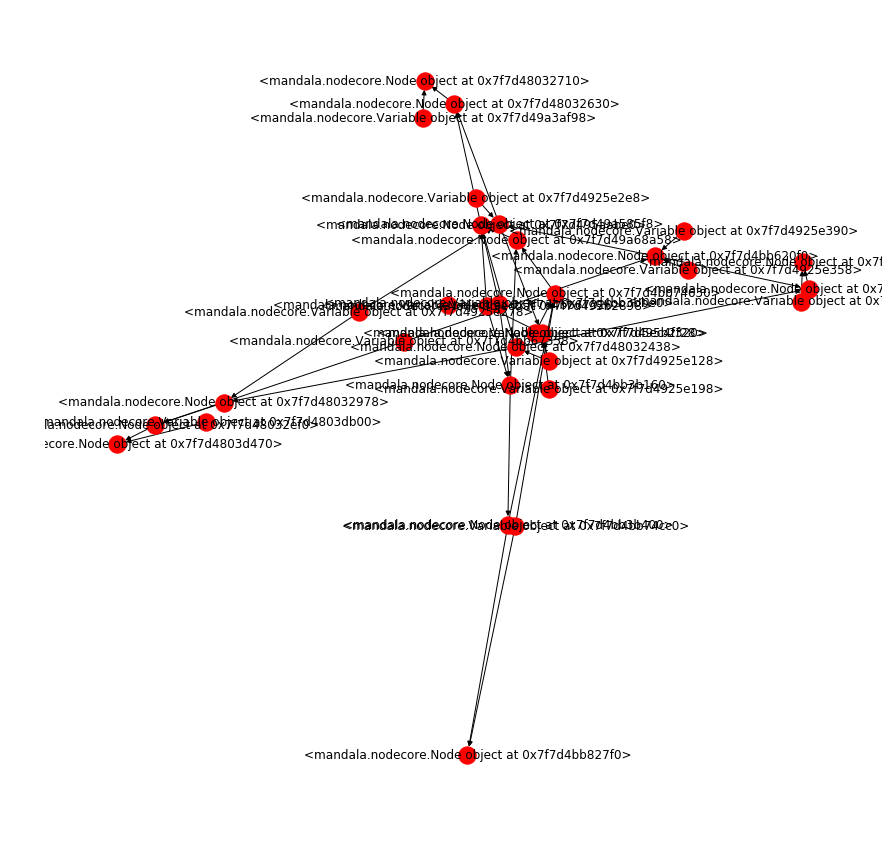

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)

plt.axis("off")
plt.savefig("default.png")
plt.show()